# Мера Жаккарда

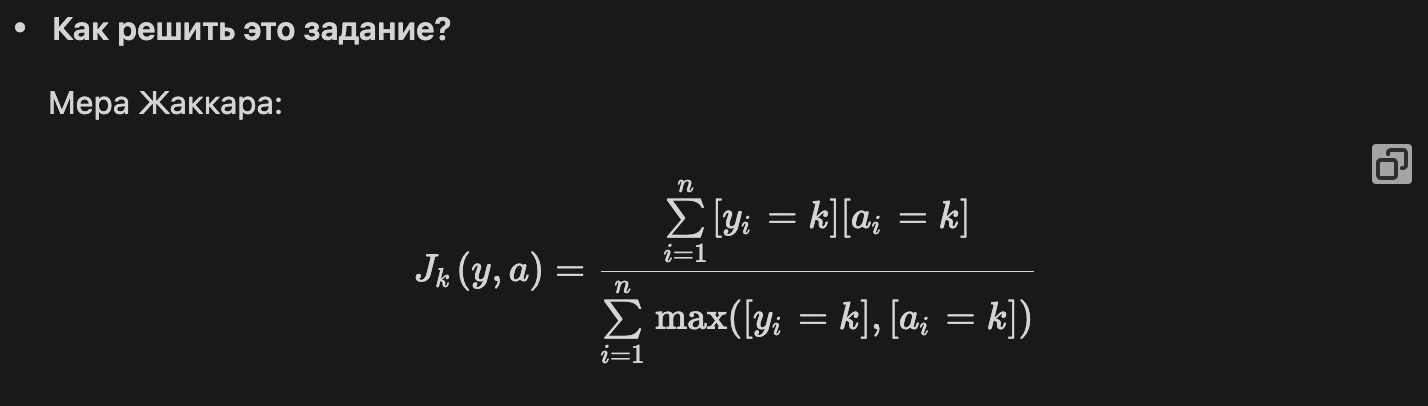


In [10]:
import torch
from torch import Tensor

y_pred = Tensor([
    [1, 1, 2, 2, 2],
    [1, 1, 2, 1, 2],
    [1, 0, 0, 0, 0],
    [2, 2, 2, 0, 0],
    [2, 1, 1, 1, 2]
])

y_true = Tensor([
    [1, 1, 1, 2, 2],
    [1, 1, 1, 2, 2],
    [1, 1, 1, 2, 2],
    [0, 0, 0, 2, 2],
    [0, 0, 0, 2, 2]
])

y_pred = y_pred.flatten()
y_true = y_true.flatten()

jaccard_scores = []

for k in range(3):
    pred_mask = (y_pred == k)
    true_mask = (y_true == k)

    intersection = (pred_mask & true_mask).sum().item()
    union = (pred_mask | true_mask).sum().item()

    jaccard = intersection / union if union != 0 else 0
    jaccard_scores.append(jaccard)

mean_jaccard = sum(jaccard_scores) / len(jaccard_scores)

print(f'Jaccard scores: {jaccard_scores}')
print(f'{mean_jaccard: .4f}')

Jaccard scores: [0.0, 0.38461538461538464, 0.25]
 0.2115


## Импорт библиотек

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms as T
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

## Тренировка модели

In [ ]:
def train(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for x, y in tqdm(train_loader, desc="Training"):
        x, y = x.to(device), y.squeeze(1).to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = output.max(dim=1)
        total += y.numel()
        correct += (predicted == y).sum().item()
    return total_loss / len(train_loader), correct / total

## Оценка модели

In [ ]:
@torch.no_grad()
def evaluate(model, valid_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    for x, y in tqdm(valid_loader, desc="Evaluation"):
        x, y = x.to(device), y.squeeze(1).to(device)
        output = model(x)
        loss = loss_fn(output, y)
        total_loss += loss.item()
        _, predicted = output.max(dim=1)
        total += y.numel()
        correct += (predicted == y).sum().item()
    return total_loss / len(valid_loader), correct / total

## Модель нейросети

In [ ]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )


class ImprovedUNET(nn.Module):
    def __init__(self, base_channels=16):
        super(ImprovedUNET, self).__init__()
        self.enc1 = conv_block(3, base_channels)
        self.enc2 = conv_block(base_channels, base_channels * 2)
        self.enc3 = conv_block(base_channels * 2, base_channels * 4)
        self.enc4 = conv_block(base_channels * 4, base_channels * 8)
        self.enc5 = conv_block(base_channels * 8, base_channels * 16)  # Дополнительный блок вниз

        self.bottleneck = conv_block(base_channels * 16, base_channels * 32)  # Увеличиваем количество каналов

        self.dec5 = conv_block(base_channels * 32, base_channels * 16)  # Дополнительный блок вверх
        self.dec4 = conv_block(base_channels * 16, base_channels * 8)
        self.dec3 = conv_block(base_channels * 8, base_channels * 4)
        self.dec2 = conv_block(base_channels * 4, base_channels * 2)
        self.dec1 = conv_block(base_channels * 2, base_channels)

        self.final = nn.Conv2d(base_channels, 3, kernel_size=1)  # 3 канала для 3 классов сегментации

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Увеличиваем количество каналов в слоях обратной свертки
        self.upconv5 = nn.ConvTranspose2d(base_channels * 32, base_channels * 16, kernel_size=2, stride=2)  # Доп. слой
        self.upconv4 = nn.ConvTranspose2d(base_channels * 16, base_channels * 8, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        enc5 = self.enc5(self.pool(enc4))  # Доп. блок

        bottleneck = self.bottleneck(self.pool(enc5))

        dec5 = self.upconv5(bottleneck)
        dec5 = torch.cat((dec5, enc5), dim=1)  # Правильное объединение
        dec5 = self.dec5(dec5)

        dec4 = self.upconv4(dec5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        return self.final(dec1)

## Импорт датасета

In [ ]:
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

target_transform = T.Compose([
    T.Resize((256, 256)),
    T.PILToTensor(),
    T.Lambda(lambda x: (x-1).long())  # Маски сегментации как одноканальные
])


train_dataset = OxfordIIITPet(
    root='./data',
    split='trainval',
    target_types='segmentation',
    download=True,
    transform=transform,
    target_transform=target_transform
)

valid_dataset = OxfordIIITPet(
    root='./data',
    split='test',
    target_types='segmentation',
    download=True,
    transform=transform,
    target_transform=target_transform
)

## Обучение и вывод результатов

In [1]:



# Используем Subset для выделения 200 изображений для валидации
np.random.seed(100)
idx = np.random.randint(len(valid_dataset), size=200)
valid_subset = Subset(valid_dataset, idx)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedUNET(base_channels=16).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()




# --- Training Loop ---
for epoch in range(30):
    print(f"Epoch {epoch + 1}/30")
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss, valid_acc = evaluate(model, valid_loader, loss_fn, device)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")


100%|██████████| 791918971/791918971 [00:28<00:00, 28195644.52it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 12293452.48it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet
Epoch 1/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.78it/s]


Train Loss: 0.6960, Train Accuracy: 0.7180
Validation Loss: 0.6103, Validation Accuracy: 0.7593
Epoch 2/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.71it/s]


Train Loss: 0.5377, Train Accuracy: 0.7878
Validation Loss: 0.4722, Validation Accuracy: 0.8187
Epoch 3/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.74it/s]


Train Loss: 0.4521, Train Accuracy: 0.8240
Validation Loss: 0.5198, Validation Accuracy: 0.7931
Epoch 4/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.00it/s]


Train Loss: 0.4094, Train Accuracy: 0.8414
Validation Loss: 0.3964, Validation Accuracy: 0.8517
Epoch 5/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.44it/s]


Train Loss: 0.3801, Train Accuracy: 0.8531
Validation Loss: 0.5582, Validation Accuracy: 0.7851
Epoch 6/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.75it/s]


Train Loss: 0.3600, Train Accuracy: 0.8612
Validation Loss: 0.3689, Validation Accuracy: 0.8601
Epoch 7/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.76it/s]


Train Loss: 0.3374, Train Accuracy: 0.8716
Validation Loss: 0.3811, Validation Accuracy: 0.8571
Epoch 8/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.66it/s]


Train Loss: 0.3212, Train Accuracy: 0.8778
Validation Loss: 0.4258, Validation Accuracy: 0.8527
Epoch 9/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.93it/s]


Train Loss: 0.3087, Train Accuracy: 0.8820
Validation Loss: 0.3426, Validation Accuracy: 0.8747
Epoch 10/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.67it/s]


Train Loss: 0.3011, Train Accuracy: 0.8854
Validation Loss: 0.3799, Validation Accuracy: 0.8642
Epoch 11/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.48it/s]


Train Loss: 0.2897, Train Accuracy: 0.8898
Validation Loss: 0.3503, Validation Accuracy: 0.8722
Epoch 12/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.71it/s]


Train Loss: 0.2729, Train Accuracy: 0.8964
Validation Loss: 0.3160, Validation Accuracy: 0.8835
Epoch 13/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.77it/s]


Train Loss: 0.2627, Train Accuracy: 0.9000
Validation Loss: 0.3386, Validation Accuracy: 0.8772
Epoch 14/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 14.00it/s]


Train Loss: 0.2534, Train Accuracy: 0.9035
Validation Loss: 0.3233, Validation Accuracy: 0.8854
Epoch 15/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.75it/s]


Train Loss: 0.2470, Train Accuracy: 0.9055
Validation Loss: 0.3194, Validation Accuracy: 0.8885
Epoch 16/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.91it/s]


Train Loss: 0.2332, Train Accuracy: 0.9106
Validation Loss: 0.3388, Validation Accuracy: 0.8855
Epoch 17/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.82it/s]


Train Loss: 0.2325, Train Accuracy: 0.9109
Validation Loss: 0.3116, Validation Accuracy: 0.8900
Epoch 18/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.71it/s]


Train Loss: 0.2254, Train Accuracy: 0.9135
Validation Loss: 0.3280, Validation Accuracy: 0.8850
Epoch 19/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.62it/s]


Train Loss: 0.2177, Train Accuracy: 0.9163
Validation Loss: 0.2977, Validation Accuracy: 0.8962
Epoch 20/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 14.00it/s]


Train Loss: 0.2089, Train Accuracy: 0.9194
Validation Loss: 0.3400, Validation Accuracy: 0.8924
Epoch 21/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.82it/s]


Train Loss: 0.2048, Train Accuracy: 0.9208
Validation Loss: 0.3049, Validation Accuracy: 0.8936
Epoch 22/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.88it/s]


Train Loss: 0.2029, Train Accuracy: 0.9216
Validation Loss: 0.3385, Validation Accuracy: 0.8919
Epoch 23/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.58it/s]


Train Loss: 0.1923, Train Accuracy: 0.9255
Validation Loss: 0.3182, Validation Accuracy: 0.8975
Epoch 24/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.85it/s]


Train Loss: 0.1837, Train Accuracy: 0.9286
Validation Loss: 0.3312, Validation Accuracy: 0.8879
Epoch 25/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.62it/s]


Train Loss: 0.1922, Train Accuracy: 0.9252
Validation Loss: 0.3367, Validation Accuracy: 0.8874
Epoch 26/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 12.84it/s]


Train Loss: 0.1856, Train Accuracy: 0.9277
Validation Loss: 0.3267, Validation Accuracy: 0.8986
Epoch 27/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.96it/s]


Train Loss: 0.1799, Train Accuracy: 0.9298
Validation Loss: 0.3298, Validation Accuracy: 0.8960
Epoch 28/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.68it/s]


Train Loss: 0.1770, Train Accuracy: 0.9308
Validation Loss: 0.3337, Validation Accuracy: 0.8893
Epoch 29/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.70it/s]


Train Loss: 0.1812, Train Accuracy: 0.9291
Validation Loss: 0.3495, Validation Accuracy: 0.8927
Epoch 30/10


Evaluation: 100%|██████████| 25/25 [00:01<00:00, 13.87it/s]

Train Loss: 0.1652, Train Accuracy: 0.9349
Validation Loss: 0.3779, Validation Accuracy: 0.8890


## Сохранение предсказаний

In [3]:
# Переключаем модель в режим оценки
model.eval()
predictions = []

# Создаем DataLoader для валидационного подмножества
valid_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False)

# Получаем предсказания
for x, _ in tqdm(valid_loader, desc="Generating Predictions"):
    x = x.to(device)
    with torch.no_grad():
        output = model(x)
    _, pred = output.max(dim=1)  # Получаем индекс максимального значения
    predictions.append(pred.cpu())  # Переносим на CPU и добавляем в список

# Объединяем предсказания в один тензор
predictions_tensor = torch.cat(predictions).unsqueeze(1)  # Формат [200, 1, 256, 256]
predictions_tensor = predictions_tensor.to(torch.uint8)  # Преобразуем в uint8

# Сохраняем предсказания
torch.save(predictions_tensor, 'predictions.pt')
print(f'Predictions saved in predictions.pt with shape {predictions_tensor.shape}')


Generating Predictions: 100%|██████████| 25/25 [00:02<00:00, 11.69it/s]


Predictions saved in predictions.pt with shape torch.Size([200, 1, 256, 256])
